In [16]:

from pyspark import SparkContext
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%time  ss = SparkSession.builder \
     .master("local") \
     .appName("Recommender System") \
     .getOrCreate()

Wall time: 3 ms


In [17]:
rating_pd_dataframe = pd.read_csv("./BX-Book-Ratings.csv", sep=';', error_bad_lines=False, encoding="latin-1")
rating_pd_dataframe.columns = ['userID', 'ISBN', 'bookRating']
print(rating_pd_dataframe.shape)
ratings = ss.createDataFrame(rating_pd_dataframe)


(1149780, 3)


In [18]:
ratings.head(5)

[Row(userID=276725, ISBN='034545104X', bookRating=0),
 Row(userID=276726, ISBN='0155061224', bookRating=5),
 Row(userID=276727, ISBN='0446520802', bookRating=0),
 Row(userID=276729, ISBN='052165615X', bookRating=3),
 Row(userID=276729, ISBN='0521795028', bookRating=6)]

In [19]:
ratings_count = ratings.groupBy('bookRating').count().collect()

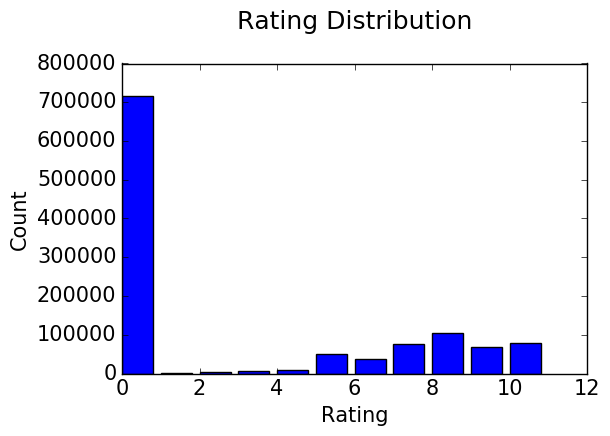

In [20]:
plt.rc("font", size=15)
plt.bar(np.arange(11), [x['count'] for x in sorted(ratings_count,key=lambda x : x['bookRating'])])
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [21]:
sorted(ratings_count,key=lambda x : x['bookRating'])

[Row(bookRating=0, count=716109),
 Row(bookRating=1, count=1770),
 Row(bookRating=2, count=2759),
 Row(bookRating=3, count=5996),
 Row(bookRating=4, count=8904),
 Row(bookRating=5, count=50974),
 Row(bookRating=6, count=36924),
 Row(bookRating=7, count=76457),
 Row(bookRating=8, count=103736),
 Row(bookRating=9, count=67541),
 Row(bookRating=10, count=78610)]

In [22]:
books_pd_dataframe = pd.read_csv("./BX-Books.csv", sep=';', error_bad_lines=False, encoding="latin-1")
books_pd_dataframe.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
print(books_pd_dataframe.shape)
print(books_pd_dataframe.count())

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell

(271360, 8)
ISBN                 271360
bookTitle            271360
bookAuthor           271360
yearOfPublication    271360
publisher            271358
imageUrlS            271360
imageUrlM            271360
imageUrlL            271357
dtype: int64


In [23]:
from pyspark.sql.types import *
field_list = [StructField(x,StringType()) for x in books_pd_dataframe.columns]
schema = StructType(field_list)

In [24]:
books = ss.createDataFrame(books_pd_dataframe, schema)
print(books.count())

271360


In [25]:
books.head(5)

[Row(ISBN='0195153448', bookTitle='Classical Mythology', bookAuthor='Mark P. O. Morford', yearOfPublication='2002', publisher='Oxford University Press', imageUrlS='http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg', imageUrlM='http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg', imageUrlL='http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg'),
 Row(ISBN='0002005018', bookTitle='Clara Callan', bookAuthor='Richard Bruce Wright', yearOfPublication='2001', publisher='HarperFlamingo Canada', imageUrlS='http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg', imageUrlM='http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg', imageUrlL='http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg'),
 Row(ISBN='0060973129', bookTitle='Decision in Normandy', bookAuthor="Carlo D'Este", yearOfPublication='1991', publisher='HarperPerennial', imageUrlS='http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg', imageUrlM='http://images.amazon.com/image

In [26]:
users_pd_dataframe = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users_pd_dataframe.columns = ['userID', 'Location', 'Age']
print(users_pd_dataframe.shape)

(278858, 3)


In [27]:
users = ss.createDataFrame(users_pd_dataframe)

In [28]:
users.head(5)

[Row(userID=1, Location='nyc, new york, usa', Age=nan),
 Row(userID=2, Location='stockton, california, usa', Age=18.0),
 Row(userID=3, Location='moscow, yukon territory, russia', Age=nan),
 Row(userID=4, Location='porto, v.n.gaia, portugal', Age=17.0),
 Row(userID=5, Location='farnborough, hants, united kingdom', Age=nan)]

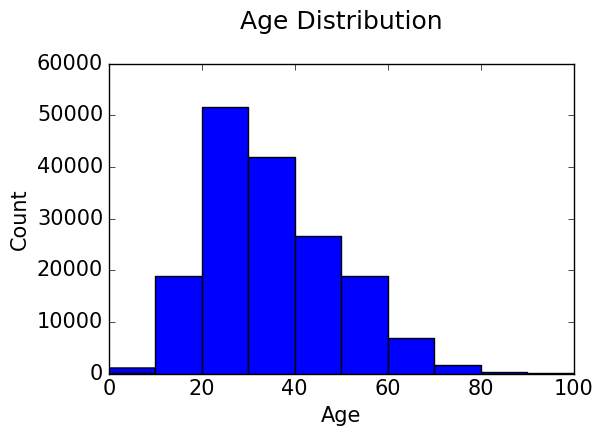

In [29]:
import math

plt.hist([x['Age'] for x in users.collect() if not math.isnan(x['Age'])], bins=np.arange(101, step=10))
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [30]:
ratings_count = sorted(ratings.groupby('ISBN').agg({"*": "count", "bookRating": "avg"}).collect(),key=lambda x : x['count(1)'], reverse=True)

In [31]:
ratings_count[0:5]

[Row(ISBN='0971880107', avg(bookRating)=1.0195843325339728, count(1)=2502),
 Row(ISBN='0316666343', avg(bookRating)=4.468725868725869, count(1)=1295),
 Row(ISBN='0385504209', avg(bookRating)=4.652321630804077, count(1)=883),
 Row(ISBN='0060928336', avg(bookRating)=3.448087431693989, count(1)=732),
 Row(ISBN='0312195516', avg(bookRating)=4.334716459197787, count(1)=723)]

In [32]:
most_rated_books_isbn = ['0971880107', '0316666343', '0385504209', '0060928336', '0312195516']
most_rated_books = books.filter(books['ISBN'].isin(most_rated_books_isbn))

In [33]:
most_rated_books.take(5)

[Row(ISBN='0971880107', bookTitle='Wild Animus', bookAuthor='Rich Shapero', yearOfPublication='2004', publisher='Too Far', imageUrlS='http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg', imageUrlM='http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg', imageUrlL='http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg'),
 Row(ISBN='0316666343', bookTitle='The Lovely Bones: A Novel', bookAuthor='Alice Sebold', yearOfPublication='2002', publisher='Little, Brown', imageUrlS='http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg', imageUrlM='http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg', imageUrlL='http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg'),
 Row(ISBN='0312195516', bookTitle='The Red Tent (Bestselling Backlist)', bookAuthor='Anita Diamant', yearOfPublication='1998', publisher='Picador USA', imageUrlS='http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg', imageUrlM='http://images.amazon.com/images/P/0312195516.01.MZZ

In [34]:
active_users = ratings.groupby('userID').count()
print(active_users.count())
active_users = active_users.filter(active_users['count'] >= 200)
print(active_users.count())
active_users.take(5)

105283
905


[Row(userID=62895, count=301),
 Row(userID=222204, count=222),
 Row(userID=30276, count=667),
 Row(userID=84024, count=374),
 Row(userID=133747, count=677)]

In [35]:
popular_books = ratings.groupby('ISBN').count()
print(popular_books.count())
popular_books = popular_books.filter(popular_books['count'] >= 100)
print(popular_books.count())
popular_books.take(5)

340556
731


[Row(ISBN='0767905385', count=143),
 Row(ISBN='0553581554', count=124),
 Row(ISBN='0842329129', count=297),
 Row(ISBN='0670865796', count=139),
 Row(ISBN='0515135739', count=102)]

In [36]:
print(ratings.count())
ratings = ratings.filter(ratings['userID'].isin([x['userID'] for x in active_users.collect()]))
print(ratings.count())

1149780
527556


In [37]:
print(ratings.count())
ratings = ratings.filter(ratings['ISBN'].isin([x['ISBN'] for x in popular_books.collect()]))
print(ratings.count())

527556
49781


In [39]:
ratings_pivot = ratings.groupby('userID').pivot('ISBN').max('bookRating')

In [40]:
len(ratings_pivot.columns)

732

In [41]:
%time ratings_pivot.corr('0316666343', '0316601950')

Wall time: 17.2 s


0.17186321371594054

In [42]:
bones_ratings = [ratings_pivot.corr('0316666343', x) for x in ratings_pivot.columns]

In [74]:
buf = sorted(bones_ratings)[-10:-1]
print(buf)

[0.17164978415283227, 0.17186321371594054, 0.18178384458348043, 0.18413719114093033, 0.18776362977349673, 0.19746988972317406, 0.20073362794989652, 0.20105055476618028, 0.21304045116973538]


In [75]:
bones_ratings_backup = bones_ratings.copy()

In [76]:
most_correlated = list()
for elem in buf:
    most_correlated.append(ratings_pivot.columns[bones_ratings.index(elem)])

In [77]:
most_correlated

['0316096199',
 '0316601950',
 '0375412824',
 '0446531332',
 '0345439104',
 '0385265700',
 '0743203631',
 '0767915054',
 '0446672211']

In [78]:
corr_books = ['0312291639', '0316601950', '0446610038', '0446672211', '0385265700', '0345342968', '0060930535', '0375707972', '0684872153']
similar_books = books.filter(books['ISBN'].isin(corr_books))

In [79]:
print((ratings_pivot.count(), len(ratings_pivot.columns)))

(888, 732)


# Книги с наибольшими корреляциями по рейтингам пользователей (из статьи на medium.com)

In [80]:
similar_books.show()

+----------+--------------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------+
|      ISBN|           bookTitle|        bookAuthor|yearOfPublication|           publisher|           imageUrlS|           imageUrlM|           imageUrlL|
+----------+--------------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------+
|0446672211|Where the Heart I...|      Billie Letts|             1998|        Warner Books|http://images.ama...|http://images.ama...|http://images.ama...|
|0060930535|The Poisonwood Bi...|Barbara Kingsolver|             1999|           Perennial|http://images.ama...|http://images.ama...|http://images.ama...|
|0375707972|          The Reader|  Bernhard Schlink|             1999|   Vintage Books USA|http://images.ama...|http://images.ama...|http://images.ama...|
|0446610038| 1st to Die: A Novel|   James Patterson|             2002|

In [81]:
similar_books = books.filter(books['ISBN'].isin(most_correlated))

# Книги с наибольшими корреляциями по рейтингам пользователей (с помощью Spark)

In [82]:
similar_books.show()

+----------+--------------------+-----------------+-----------------+----------------+--------------------+--------------------+--------------------+
|      ISBN|           bookTitle|       bookAuthor|yearOfPublication|       publisher|           imageUrlS|           imageUrlM|           imageUrlL|
+----------+--------------------+-----------------+-----------------+----------------+--------------------+--------------------+--------------------+
|0446672211|Where the Heart I...|     Billie Letts|             1998|    Warner Books|http://images.ama...|http://images.ama...|http://images.ama...|
|0446531332|  Nights in Rodanthe|  Nicholas Sparks|             2002|    Warner Books|http://images.ama...|http://images.ama...|http://images.ama...|
|0385265700|The Book of Ruth ...|    Jane Hamilton|             1990|          Anchor|http://images.ama...|http://images.ama...|http://images.ama...|
|0375412824|The Dive From Cla...|       ANN PACKER|             2002|           Knopf|http://images.